# Combined Model

This model notebook evaluates the combined model compared to a linear baseline

In [11]:
# Import
from torch import nn
from torch.utils.data import DataLoader

from models.models import *
from datasets.datasets import *
from utils import *

In [12]:
# Meta
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(f"Device: {device}")

Device: cuda


# Dataset

In [13]:
NL=[1,2,3,4,5]
dataset = get_combined_dataset(NL)

reading file
Loaded 13794 rows.
Normalizing features
['GP', 'G', 'A', 'PTS', 'PS', 'EV', 'PP', 'S']
Loading player data
creating dataset structure
creating player dict
Targets
['W%', 'L%', 'S']
Normalizing features
[]
All features
['W%', 'L%', 'GF/G', 'GA/G', 'PIM/G', 'oPIM/G', 'S', 'S%', 'SV%']
Loading player data
creating dataset structure


# Dataloader

In [14]:
batch_size = 100

N_datasets = dataset.random_split(0.2)

N_datasets_train = []
N_datasets_test = []
N_dataloaders_train = {}   
N_dataloaders_test = {}

for (N, train_dataset, test_dataset) in N_datasets:
    N_datasets_train.append(PlayerDataset(train_dataset, max_N=N))
    N_datasets_test.append(PlayerDataset(test_dataset, max_N=N))

    print(f"Train size for {N} seasons: {len(N_datasets_train[-1])}")
    print(f"Test size for {N} seasons: {len(N_datasets_test[-1])}")

    N_dataloaders_train[N] = (DataLoader(N_datasets_train[-1], batch_size=batch_size, shuffle=True))
    N_dataloaders_test[N] = (DataLoader(N_datasets_test[-1], batch_size=batch_size, shuffle=True))


print(N_datasets_train[0].__getitem__(0))

Train size for 1 seasons: 6854
Test size for 1 seasons: 1712
Train size for 2 seasons: 4762
Test size for 2 seasons: 1203
Train size for 3 seasons: 3379
Test size for 3 seasons: 852
Train size for 4 seasons: 2403
Test size for 4 seasons: 609
Train size for 5 seasons: 1720
Test size for 5 seasons: 437
(tensor([[-1.6527, -1.4110, -1.6841, -1.8132, -0.9924, -1.3815, -0.7603, -1.3270,
          0.0163,  0.0551, -0.7202, -0.1771, -0.6881, -0.5438,  0.7645, -1.2591,
         -0.1437]]), tensor([ 0.7835, -0.1871, -0.0886, -0.0875,  0.2850, -0.0260, -0.7603,  0.5293]))


# Training and Validation

In [15]:
player_params ={
    "input_size": 8,
    "hidden_size": 10,
    "MLP_hidden_size": 10,
    "num_layers": 1,
    "lr": 0.001,
    "epochs": 50,
    "loss_interval": 5
}
team_params ={
    "input_size": 9,
    "output_size": 3,
    "hidden_size": 10,
    "num_layers": 1
}

hidden_size = 10
epochs= 50
loss_interval = 5  


combined_model = PlayerCombined(
    player_input_size=player_params["input_size"],
    player_hidden_size=player_params["hidden_size"],
    player_MLP_hidden_size=player_params["MLP_hidden_size"],
    team_input_size=team_params["input_size"],
    team_output_size=team_params["output_size"],
    team_hidden_size=team_params["hidden_size"],
    hidden_size=hidden_size,
    num_layers=player_params["num_layers"],
    team_num_layers=team_params["num_layers"],
    device=device
).to(device)

#load parameter for submodules
player_state_dict = torch.load("models/checkpoints/player_standalone_all_N.pth")
team_state_dict = torch.load("models/checkpoints/team_standalone_all_N.pth")

combined_model.player_standalone.load_state_dict(player_state_dict)
combined_model.team_standalone.load_state_dict(team_state_dict)

#freeze submodules
for param in combined_model.player_standalone.parameters():
    param.requires_grad = False
for param in combined_model.team_standalone.parameters():
    param.requires_grad = False



print(combined_model.named_parameters)






<bound method Module.named_parameters of PlayerCombined(
  (player_standalone): PlayerStandalone_Latent(
    (lstm): LSTM(8, 10, batch_first=True)
    (mid): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): ReLU()
    )
    (out): Linear(in_features=10, out_features=8, bias=True)
  )
  (team_standalone): TeamStandalone_Latent(
    (lstm): LSTM(9, 10, batch_first=True)
    (mid): Sequential(
      (0): Linear(in_features=10, out_features=20, bias=True)
      (1): ReLU()
    )
    (lin): Linear(in_features=20, out_features=12, bias=True)
    (out): Linear(in_features=12, out_features=3, bias=True)
  )
  (mid): Sequential(
    (0): Linear(in_features=30, out_features=10, bias=True)
    (1): ReLU()
  )
  (out): Linear(in_features=10, out_features=8, bias=True)
)>


In [16]:
criterion = RMSELoss()
optimizer = torch.optim.Adam(combined_model.parameters(), lr=player_params["lr"])
(combined_model, train_losses,val_losses) = train_and_validate_varying_N(combined_model, criterion, optimizer, N_dataloaders_train, N_dataloaders_test, epochs=epochs, loss_interval=loss_interval, device=device)

model_combined_losses = (train_losses, val_losses)

0 th epoch :  0.8885041548146142
Validation loss for epoch 0: 0.8157084389374807
Validation loss for epoch 5: 0.6153462351514742
10 th epoch :  0.5934334523148007
Validation loss for epoch 10: 0.5968970404221461
Validation loss for epoch 15: 0.6008326881206952
20 th epoch :  0.5950207981798384
Validation loss for epoch 20: 0.5956207691476896
Validation loss for epoch 25: 0.5975318081103839
30 th epoch :  0.5987585577699873
Validation loss for epoch 30: 0.5987214904565078
Validation loss for epoch 35: 0.592096093755502
40 th epoch :  0.598444390628073
Validation loss for epoch 40: 0.5894405979376572
Validation loss for epoch 45: 0.5963466505591686


In [17]:
#evaluate model trained on all N for individual N
criterion = RMSELoss()
model_combined_losses_N = []
for i in range(5):
    avg_pred = []
    avg_target = []
    for (x, y) in N_datasets_train[i]:
        pred = combined_model(x.unsqueeze(0).to(device))[0]
        avg_pred.append(pred.cpu().detach())
        avg_target.append(y)
    avg_pred = torch.stack(avg_pred)
    avg_target = torch.stack(avg_target)
    train_loss = criterion(avg_pred, avg_target)
    
    avg_pred = []
    avg_target = []
    for (x, y) in N_datasets_test[i]:
        pred = combined_model(x.unsqueeze(0).to(device))[0]
        avg_pred.append(pred.cpu().detach())
        avg_target.append(y)
    avg_pred = torch.stack(avg_pred)
    avg_target = torch.stack(avg_target)
    test_loss = criterion(avg_pred, avg_target)
    model_combined_losses_N.append((train_loss, test_loss))

In [27]:

class CombinedLinear(nn.Module):
    def __init__(self, input_size, output_size, N, device="cpu"):
        super(CombinedLinear, self).__init__()

        self.input_size = input_size * N
        self.output_size = output_size
        self.device = device
        self.N = N

        self.out = nn.Linear(self.input_size, self.output_size)


    def forward(self, x):
        
        #if x has length < N, pad with zeros
        if len(x[0]) < self.N:
            padded_x = []
            pads = [torch.zeros_like(x[0][0]) for i in range(self.N - len(x[0]))]
            #use pre-padding
            for i in range(x.size(0)):
                padded_x.append(torch.cat((torch.stack(pads), x[i]), dim=0))
            x = torch.stack(padded_x)
        
        #if x is a 3D tensor, flatten dim 2 and 3
        if len(x.size()) == 3:
            x = x.view(x.size(0), -1)
        
        out = self.out(x)
        return out


In [28]:
lr = 0.001
epochs = 50
loss_interval = 5

# Train on all data
print("Training model for all seasons")
input_size = len(N_datasets_train[0].__getitem__(0)[0][0])
model_linear_all = CombinedLinear(input_size=17, output_size=8, N=5, device=device).to(device)
criterion = RMSELoss()
optimizer = torch.optim.Adam(model_linear_all.parameters(), lr=lr)
(model_linear_all, train_losses,val_losses) = train_and_validate_varying_N(model_linear_all, criterion, optimizer, N_dataloaders_train, N_dataloaders_test, epochs=epochs, loss_interval=loss_interval, device=device)

model_linear_all_losses = (train_losses, val_losses)

Training model for all seasons
0 th epoch :  0.7569762812720404
Validation loss for epoch 0: 0.6790482780108085
Validation loss for epoch 5: 0.6224599956319883
10 th epoch :  0.6201391723420885
Validation loss for epoch 10: 0.6163923167265378
Validation loss for epoch 15: 0.6217055870936468
20 th epoch :  0.618098325530688
Validation loss for epoch 20: 0.6243106430539718
Validation loss for epoch 25: 0.6204868532144107
30 th epoch :  0.6135702437824673
Validation loss for epoch 30: 0.6153055819181296
Validation loss for epoch 35: 0.6162479233283263
40 th epoch :  0.6141780177752177
Validation loss for epoch 40: 0.6080044851853297
Validation loss for epoch 45: 0.6065447943714949


In [29]:
model_linear_all_losses_N = []
for i in range(5):
    avg_pred = []
    avg_target = []
    for (x, y) in N_datasets_train[i]:
        pred = model_linear_all(x.unsqueeze(0).to(device))[0]
        avg_pred.append(pred.cpu().detach())
        avg_target.append(y)
    avg_pred = torch.stack(avg_pred)
    avg_target = torch.stack(avg_target)
    train_loss = criterion(avg_pred, avg_target)
    
    avg_pred = []
    avg_target = []
    for (x, y) in N_datasets_test[i]:
        pred = model_linear_all(x.unsqueeze(0).to(device))[0]
        avg_pred.append(pred.cpu().detach())
        avg_target.append(y)
    avg_pred = torch.stack(avg_pred)
    avg_target = torch.stack(avg_target)
    test_loss = criterion(avg_pred, avg_target)
    model_linear_all_losses_N.append((train_loss, test_loss))

# Plot Results

[tensor(0.6437), tensor(0.6003), tensor(0.5663), tensor(0.5531), tensor(0.5487)]
[tensor(0.6707), tensor(0.6124), tensor(0.5728), tensor(0.5652), tensor(0.5641)]


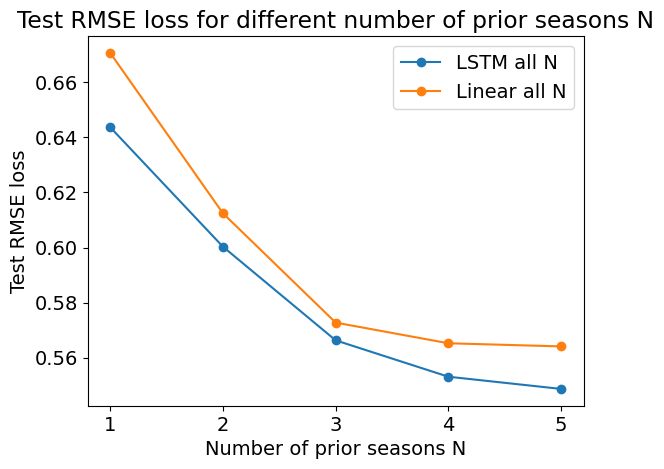

In [31]:
#plot seaons on x-axis and final validation loss on y-axis
plt.title('Test RMSE loss for different number of prior seasons N')

plt.plot(range(1,6), [model_combined_losses_N[i][1] for i in range(5)], label='LSTM all N',marker='o')
plt.plot(range(1,6), [model_linear_all_losses_N[i][1] for i in range(5)], label='Linear all N',marker='o')

plt.xlabel('Number of prior seasons N')
plt.ylabel('Test RMSE loss')
plt.xticks(range(1,6))
plt.legend()

#print test losses
print([model_combined_losses_N[i][1] for i in range(5)])
print([model_linear_all_losses_N[i][1] for i in range(5)])

The printed tensors are manually copied to the player_standalone_eval notebook to compare the results.

In [21]:
#save model_all to file
torch.save(combined_model.state_dict(), 'models/checkpoints/player_combined_all_N.pth')

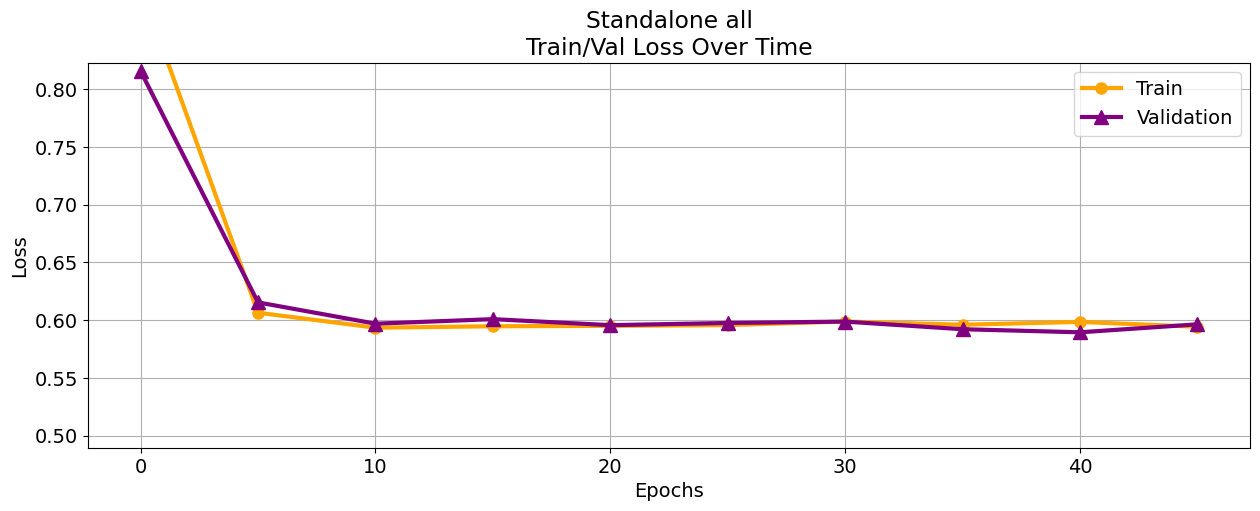

In [23]:
#plot training loss and validation loss for model_all_losses
plot_train_v_loss('Standalone all',model_combined_losses[0], model_combined_losses[1], 5)

In [32]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

print(get_n_params(combined_model))
print(get_n_params(model_linear_all))

2747
688
